In [27]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import numpy as np
import scipy as sc
import pymc3 as pm
import theano.tensor as tt
import arviz as az

from gradient_free_optimizers import *
from nd2reader import ND2Reader

Set parameters: path to data, horizontal position of channel, frames-per-second and pixel width, ROPEs

In [28]:
# path to data
basepath = "/home/cb51neqa/projects/itp/exp_data/2021-12-20/5µA/"
concentration = "AF647_10ng_l/"
number = "005.nd2"
inname = basepath + concentration + number

# pixel in y direction containing the channel from the middle 
channel_lower = 27
channel_upper = 27

# frames per second (fps)
fps = 46
# size of one pixel (m/px)
px = 1.6e-6

# ROPEs of velocity, spread, and snr
rope_velocity = (130,190) # (microm/s)
rope_sigma = (4,11) # (px)
snr_ref = 3 


figsize = np.array([8,8])

Load the fluoresence images, cut in vertical direction to channel width, and substract background fluoresence

In [29]:
# load images from disk
with ND2Reader(inname) as rawimages:
    # determine metadata of the images
    Y = rawimages.metadata["height"]
    X = rawimages.metadata["width"]
    N = rawimages.metadata["num_frames"]
   
    # to numpy array
    # Y x X x N
    data_raw = np.zeros((Y, X, N))
    for i,frame in enumerate(np.arange(0, N)):
        data_raw[:,:,i] = rawimages[frame]

# cut image height to channel width
height = data_raw.shape[0]
frow = int(height/2 - channel_lower)
lrow = int(height/2 + channel_upper)
data_raw = data_raw[frow:lrow,:,:]

# subtract background fluoresence without any sample present
background = np.mean(data_raw[:,:,0:50], axis=2)
data_raw = data_raw - background.reshape(background.shape[0], background.shape[1],1)

Average data over vertical direction or channel width. And standardize data.

In [30]:
def standardize(data, axis=None):
    return (data-np.mean(data, axis=axis))/np.std(data, axis=axis)

In [31]:
data = np.mean(data_raw, axis=0)
data = standardize(data, axis=0)

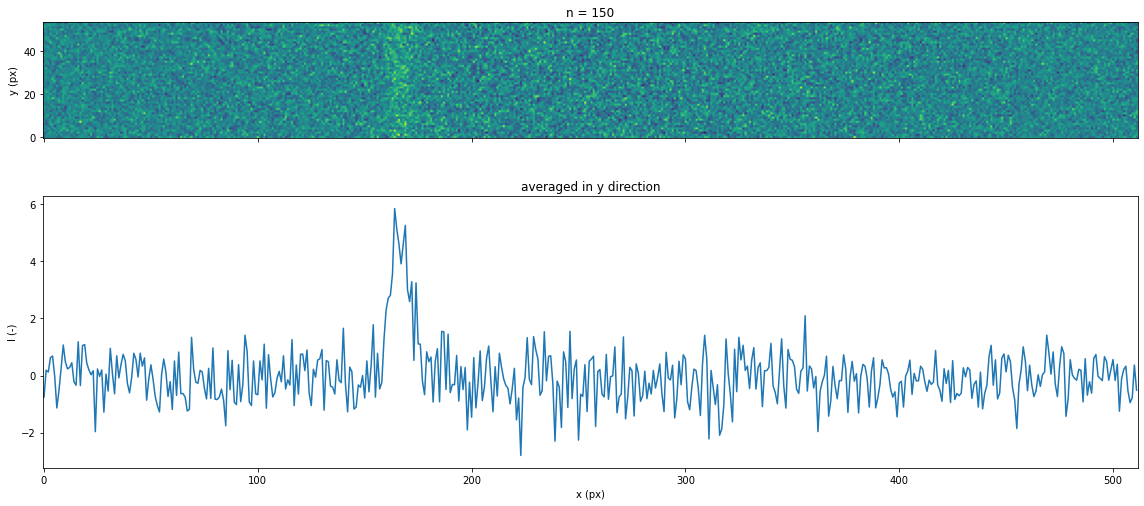

In [32]:
fig, axs = plt.subplots(2,1, figsize=(2*figsize[0], figsize[1]), sharex=True)

time = 150
axs[0].imshow(data_raw[:,:,time], origin="lower");
axs[0].set_title("n = {}".format(time))
axs[0].set_ylabel("y (px)");

axs[1].plot(data[:,time])
axs[1].set_title("averaged in y direction")
axs[1].set_xlabel("x (px)")
axs[1].set_ylabel("I (-)")
                        
fig.tight_layout();

Apply Fourier filter to data

In [33]:
def fourierfilter(data, rx, ry, rotation, horizontal, vertical):
    ff = np.fft.fft2(data)
    ff = np.fft.fftshift(ff)
       
    X, Y = ff.shape
        
    window_y = sc.signal.windows.gaussian(Y, std=ry)[:,None]
    window_x = sc.signal.windows.gaussian(X, std=rx)[:,None]
    window2d = np.sqrt(np.dot(window_x, window_y.T)) # expand to 2D
    window2d = sc.ndimage.interpolation.rotate(window2d, angle=rotation, reshape=False)
    
    # remove strong horizontal and vertical frequency components
    if horizontal:
        window2d[int(X/2),:] = 0
    if vertical:
        window2d[:,int(Y/2)] = 0
    
    ffw = window2d * ff
    
    iff = np.fft.ifftshift(ffw)
    iff = np.fft.ifft2(iff)
    
    return np.real(iff), window2d, ff

In [34]:
data_fft, mask, ff = fourierfilter(data, 100, 40/4, -45, True, True)
data_fft = standardize(data_fft, axis=0)

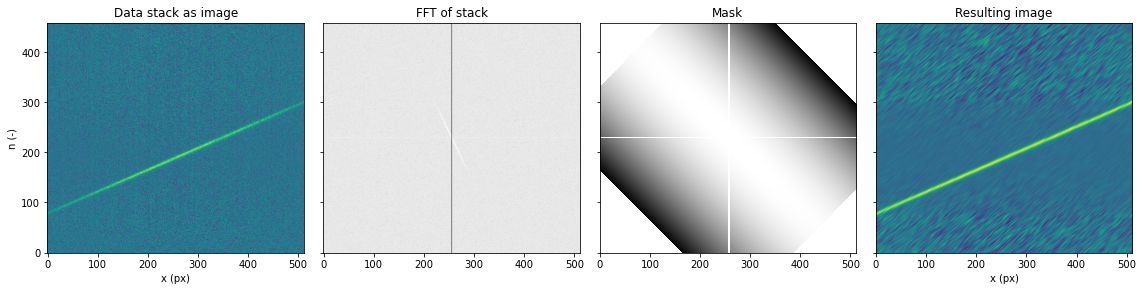

In [35]:
fig, axs = plt.subplots(1,4, figsize=(figsize[0]*2, figsize[1]), sharey=True)

axs[0].imshow(data.T, origin="lower")
axs[0].set_xlabel("x (px)")
axs[0].set_ylabel("n (-)");
axs[0].set_title("Data stack as image")

axs[1].imshow(np.log(np.abs(ff.T)), cmap="gray", origin="lower")
axs[1].set_title("FFT of stack")

axs[2].imshow(np.log(mask.T), cmap="gray", origin="lower");
axs[2].set_title("Mask")

axs[3].imshow(data_fft.T, origin="lower")
axs[3].set_xlabel("x (px)")
axs[3].set_title("Resulting image")

fig.tight_layout();

Calculate cross-correlation function with different frame lags inbetween and average all the frames.

In [36]:
def correlate_frames(data, step):
    corr = np.zeros((data.shape[0], data.shape[1]-step))
    for i in range(0,data.shape[1]-step):
        corr[:,i] = np.correlate(data[:,i], data[:,i+step], "same")

    return corr

def correlation(data, startframe, endframe, lagstepstart=30, deltalagstep=5, N=8):
    length = int(data.shape[0]/2)
    corr_mean_combined = np.zeros((N, length))

    for i in range(0, N):
        lagstep = lagstepstart + i*deltalagstep
        corr = correlate_frames(data, lagstep)
        corr = standardize(corr)
        
        corr_mean = np.mean(corr[:,startframe:endframe-lagstep], axis=1)
        
        # clean the correlation data
        # remove peak at zero lag
        corr_mean[length] = 0
        #cut everything right of the middle (because we know that the velocity is positiv)
        corr_mean = corr_mean[0:length]
    
        corr_mean_combined[i,:] = standardize(corr_mean)
        
    x_lag = np.arange(-length, 0)
        
    return x_lag, corr_mean_combined

In [37]:
def signalmodel_correlation(data, x, px, deltalagstep, lagstepstart, fps):
    
    N = x.shape[1]
    length = x.shape[0]
    
    with pm.Model() as model:
        # background
        c = pm.Normal('c', 0, 1, shape=1)
        background = pm.Deterministic("background", c)

        # sample peak
        amp = pm.HalfNormal('amplitude', 10, shape=1)
        measure = pm.Uniform("measure", 0, 1, shape=1)
        cent = pm.Deterministic('centroid', measure*length)
        if N > 1:
            deltacent = pm.HalfNormal("deltac", 20, shape=1)
        else:
            deltacent = 0
        sig = pm.HalfNormal('sigma', 50, shape=1)
        
        def sample(amp, cent, deltacent, sig, x):
            n = np.arange(0,N)
            return amp*tt.exp(-(cent + deltacent*n - x)**2/2/sig**2)
        
        sample = pm.Deterministic("sample", sample(amp, cent, deltacent, sig, x))
        
        # background + sample
        signal = pm.Deterministic('signal', background + sample)

        # prior noise
        sigma_noise = pm.HalfNormal('sigmanoise', 1, shape=1)

        # likelihood       
        likelihood = pm.Normal('y', mu = signal, sd=sigma_noise, observed = data)
        
        # derived quantities
        velocitypx = pm.Deterministic("velocitypx", (cent + deltacent)/(lagstepstart + deltalagstep))
        velocity = pm.Deterministic("velocity", velocitypx*px*fps*1e6)

        return model

In [38]:
N = 4
deltalagstep = 10
lagstepstart = 30

startframe = 100
endframe = 300

# or find the start and end frame by minimizing the width of the HDI of the velocity
if False:
    def functional(parameters):
        startframe = parameters["start"]
        delta = parameters["delta"]
        endframe = startframe + delta
    
        x_lag, corr_mean_combined = correlation(data_fft, startframe, endframe, lagstepstart=lagstepstart, deltalagstep=deltalagstep, N=N)
    
        try:
            with signalmodel_correlation(corr_mean_combined.T, -np.array([x_lag,]*N).T, px, deltalagstep, lagstepstart, fps) as model:
                trace = pm.sample(2000, tune=2000, return_inferencedata=False, cores=4, target_accept=0.9)
                idata = az.from_pymc3(trace=trace, model=model) 
    
                hdi_velocity = az.hdi(idata, var_names="velocity").velocity.values[0]
                s = hdi_velocity[1] - hdi_velocity[0]
                result = -1/2*np.sqrt(s**2)# + 1e-4*delta
                return result
        except Exception as e:
             print(e)
    
    search_space = {"start": np.arange(50, 300, 25), "delta": np.arange(150, 250, 25)}
    initialize = {"warm_start": [{"start": startframe, "delta": endframe-startframe}]}
    
    opt = BayesianOptimizer(search_space, initialize=initialize)
    opt.search(functional, n_iter=20, early_stopping={"n_iter_no_change":5}, max_score=-2)
    
    startframe = opt.best_para["start"]
    delta = opt.best_para["delta"]
    endframe = startframe + delta
    
x_lag, corr_mean_combined = correlation(data_fft, startframe, endframe, lagstepstart=lagstepstart, deltalagstep=deltalagstep, N=N)

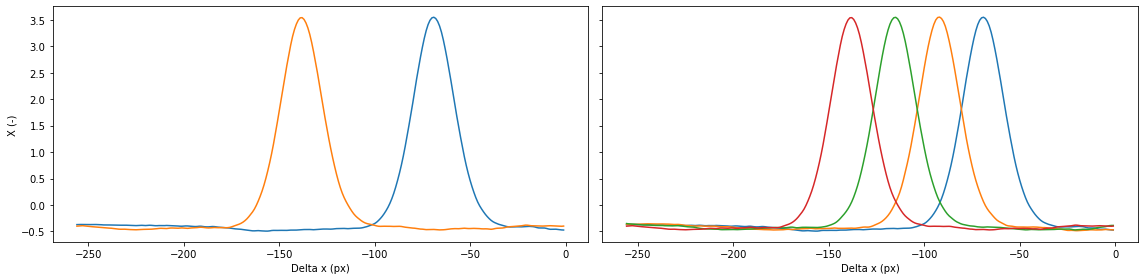

In [39]:
fig, axs = plt.subplots(1,2, figsize=(figsize[0]*2, figsize[1]/2), sharey=True)

axs[0].plot(x_lag, corr_mean_combined.T[:,0]);
axs[0].plot(x_lag, corr_mean_combined.T[:,-1]);
axs[0].set_xlabel("Delta x (px)")
axs[0].set_ylabel("X (-)");

axs[1].plot(x_lag, corr_mean_combined.T);
axs[1].set_xlabel("Delta x (px)");

fig.tight_layout()

Fit Bayesian model to the cross-correlation functions to obtain isotachophoretic velocity (of course we did that already above while looking for the optimal start and end frames).

In [40]:
with signalmodel_correlation(corr_mean_combined.T, -np.array([x_lag,]*N).T, px, deltalagstep, lagstepstart, fps) as model:
    trace = pm.sample(2000, tune=2000, return_inferencedata=False, cores=4, target_accept=0.9)
      
    ppc = pm.fast_sample_posterior_predictive(trace, model=model)
    idata = az.from_pymc3(trace=trace, posterior_predictive=ppc, model=model) 
    hdi = az.hdi(idata.posterior_predictive, hdi_prob=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigmanoise, sigma, deltac, measure, amplitude, c]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 9 seconds.


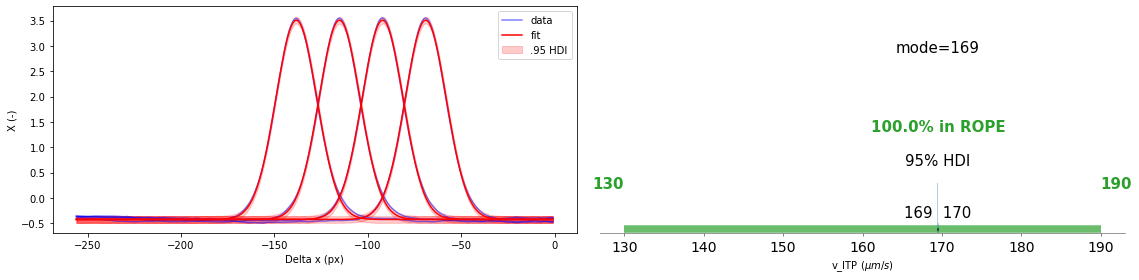

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(figsize[0]*2, figsize[1]/2))
axs[0].plot(x_lag, corr_mean_combined.T, "b", alpha=0.5, label="data");
axs[0].plot(x_lag, idata.posterior_predictive.mean(("chain", "draw"))["y"], label="fit", color="r")
axs[0].set_xlabel("Delta x (px)")
axs[0].set_ylabel("X (-)")

for i in range(0,N):
    axs[0].fill_between(x_lag, hdi["y"][:,i,0], hdi["y"][:,i,1], alpha=0.2, label=".95 HDI", color="r");

handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend([handles[0], handles[N], handles[-1]], [labels[0], labels[N], labels[-1]]);

rope = {'sigma': [{'rope': rope_sigma}]
        , 'velocity': [{'rope': rope_velocity}]}

az.plot_posterior(idata, ["velocity"], hdi_prob=.95, point_estimate="mode", kind="hist", rope=rope, ax=axs[1])
axs[1].set_title("")
axs[1].set_xlabel(r"v_ITP ($\mu m/s$)");

fig.tight_layout()

Shift data with most probable velocity

In [42]:
# get mode of velocity distribution
_, vals = az.sel_utils.xarray_to_ndarray(idata.posterior, var_names=["velocity"])
v = [az.plots.plot_utils.calculate_point_estimate("mode", val) for val in vals][0]*1e-6

# velocity in px/frame
v_px = v/(fps*px)
    
# shift data
data_shifted = np.zeros(data.shape)
for i in range(0, data.shape[1]):
    shift = data.shape[0] - int(i*v_px)
    data_shifted[:,i] = np.roll(data[:,i], shift)

Again apply Fourier filter to data stack

In [43]:
data_fft_shifted, mask_shifted, ff_shifted = fourierfilter(data_shifted, 30, 30, 0, True, False)
data_fft_shifted = standardize(data_fft_shifted)

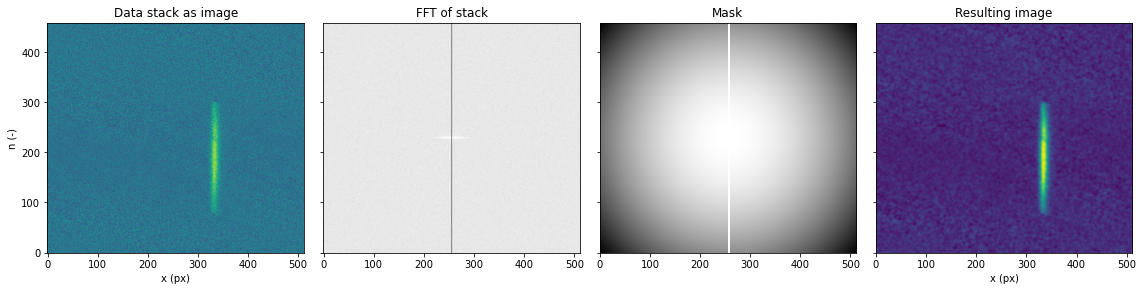

In [44]:
fig, axs = plt.subplots(1,4, figsize=2*figsize, sharey=True)

axs[0].imshow(data_shifted.T, origin="lower")
axs[0].set_xlabel("x (px)")
axs[0].set_ylabel("n (-)");
axs[0].set_title("Data stack as image")

axs[1].imshow(np.log(np.abs(ff_shifted.T)), cmap="gray", origin="lower")
axs[1].set_title("FFT of stack")

axs[2].imshow(np.log(mask_shifted.T), cmap="gray", origin="lower");
axs[2].set_title("Mask")

axs[3].imshow(data_fft_shifted.T, origin="lower")
axs[3].set_xlabel("x (px)")
axs[3].set_title("Resulting image")

fig.tight_layout();

Average the frames

In [45]:
data_mean = np.mean(data_fft_shifted[:,startframe:endframe], axis=1)
data_mean = standardize(data_mean)

Fit Bayesian model to the shifted and averaged data

In [46]:
x = np.arange(0, data_mean.shape[0])
    
with pm.Model() as model:
    # background
    c = pm.Normal('c', 0, 0.01)
    background = pm.Deterministic("background", c)

    # sample peak
    amp = pm.HalfNormal('amplitude', 10)
    measure = pm.Uniform("measure", 0, 1)
    cent = pm.Deterministic('centroid', measure*len(data_mean))
    sig = pm.HalfNormal('sigma', 20) 
    alpha = pm.Normal("alpha", 0, 0.1)       
    
    def model_sample(a, c, w, alpha, x):       
        return a*tt.exp(-(c - x)**2/2/w**2) * (1-tt.erf((alpha*(c - x))/tt.sqrt(2)/w))
    
    sample = pm.Deterministic("sample", model_sample(amp, cent, sig, alpha, x))
        
    # background + sample
    signal = pm.Deterministic('signal', background + sample)

    # prior noise
    sigma_noise = pm.HalfNormal('sigmanoise', 1.0)

    # likelihood       
    likelihood = pm.Normal('y', mu = signal, sd=sigma_noise, observed = data_mean)

    # derived quantities
    def fmax(A, c, sigma, a):
        erf = tt.erf
        sqrt = tt.sqrt
        pi = np.pi
        exp = tt.exp
        Abs = pm.math.abs_
        sign = pm.math.sgn
        return A*(erf(sqrt(2)*a*(-sqrt(2)*a*(2 - pi/2)/(pi**(3/2)*sqrt(a**2 + 1)*(-2*a**2/(pi*(a**2 + 1)) + 1)**1.0) + sqrt(2)*a/(sqrt(pi)*sqrt(a**2 + 1)) - exp(-2*pi/Abs(a))*sign(a)/2)/2) + 1)*exp(-(-sqrt(2)*a*(2 - pi/2)/(pi**(3/2)*sqrt(a**2 + 1)*(-2*a**2/(pi*(a**2 + 1)) + 1)**1.0) + sqrt(2)*a/(sqrt(pi)*sqrt(a**2 + 1)) - exp(-2*pi/Abs(a))*sign(a)/2)**2/2)
    
    fmax_ = pm.Deterministic("fmax", fmax(amp, cent, sig, alpha))
    snr = pm.Deterministic("snr", fmax_/sigma_noise)
    
    # perform sampling
    trace3 = pm.sample(2000, tune=4000, return_inferencedata=False, cores=4, target_accept=0.9)
          
    ppc3 = pm.fast_sample_posterior_predictive(trace3, model=model)
    idata3 = az.from_pymc3(trace=trace3, posterior_predictive=ppc3, model=model) 
    hdi3 = az.hdi(idata3.posterior_predictive, hdi_prob=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigmanoise, alpha, sigma, measure, amplitude, c]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 20 seconds.
The number of effective samples is smaller than 25% for some parameters.


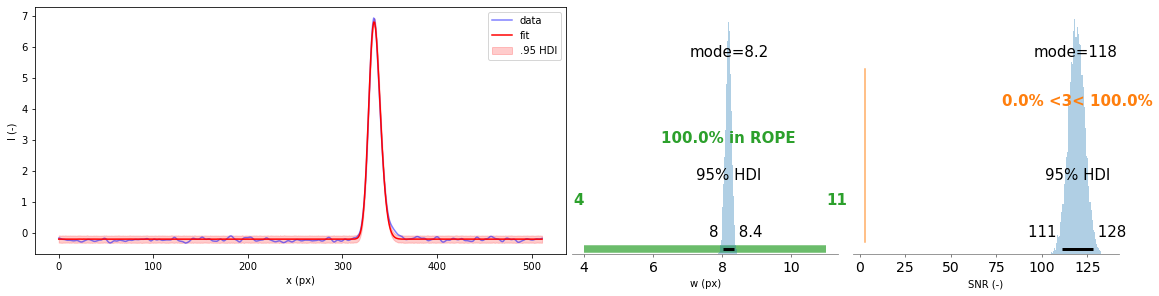

In [47]:
fig = plt.figure(constrained_layout=True, figsize=(figsize[0]*2, figsize[1]/2))
gs = GridSpec(1, 4, figure=fig)

ax = fig.add_subplot(gs[0, 0:2])
ax.plot(x, data_mean, "b", alpha=0.5, label="data");
ax.plot(x, idata3.posterior_predictive.mean(("chain", "draw"))["y"], label="fit", color="r")
ax.set_xlabel("x (px)")
ax.set_ylabel("I (-)")
ax.fill_between(x, hdi3["y"][:,0], hdi3["y"][:,1], alpha=0.2, label=".95 HDI", color="r");
ax.legend()

ax = fig.add_subplot(gs[0, 2])
az.plot_posterior(idata3, "sigma", hdi_prob=.95, point_estimate="mode", kind="hist", rope=rope, ax=ax)
ax.set_title("")
ax.set_xlabel(r"w (px)");

ax = fig.add_subplot(gs[0, 3])
az.plot_posterior(idata3, "snr", hdi_prob=.95, point_estimate="mode", kind="hist", rope=rope, ax=ax, ref_val=3)
ax.set_title("")
ax.set_xlabel(r"SNR (-)");

#fig.tight_layout()

Decide a sample is present by comparing the 95% HDIs of velocity, spread, and SNR with their ROPEs

Got error No model on context stack. trying to find log_likelihood in translation.
/home/cb51neqa/miniconda3/envs/itp/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


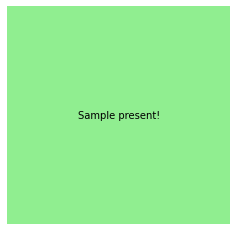

In [48]:
fig, ax = plt.subplots(figsize=figsize/2)
ax.axis('off')

# get 95% HDIs from posterior traces
idata = az.from_pymc3(trace=trace) 
hdi = az.hdi(idata.posterior, hdi_prob=.95)

idata3 = az.from_pymc3(trace=trace3) 
hdi3 = az.hdi(idata3.posterior, hdi_prob=.95)

# compare HDIs to ROPEs
if      int(hdi.velocity[0][0]>=rope_velocity[0] and hdi.velocity[0][1]<=rope_velocity[1]) \
    and int(hdi3.sigma[0]>=rope_sigma[0] and hdi3.sigma[1]<=rope_sigma[1]) \
    and int(hdi3.snr[0]>=snr_ref and hdi3.snr[1]<=1e9): # snr is compared to a one-sided ROPE or reference value 
    
    rect = mpl.patches.Rectangle((0, 0), 1, 1, facecolor='lightgreen')
    ax.add_patch(rect)
    ax.text(0.5, 0.5, 'Sample present!', horizontalalignment='center', verticalalignment='center')
else:
    rect = mpl.patches.Rectangle((0, 0), 1, 1, facecolor='lightcoral')
    ax.add_patch(rect)
    ax.text(0.5, 0.5, 'Sample absent!', horizontalalignment='center', verticalalignment='center')